# Basic usage with model selection

In this tutorial we demonstrate a further usage of harmonic, using emcee as the sampler. Additionally we perform cross-validation to select the best model in addition to optimizing the hyperparameters of said model.

## Import packages

To begin with we need to import packages needed.

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from functools import partial
import sys
sys.path.insert(0, '..')
import harmonic as hm
sys.path.append("../examples")
import utils

## Define Bayesian posterior function

Now we will need to define the log-posterior function of interest. 

As a working example for this tutorial we consider a likelihood given by the Rastrigin function

$$
f(x) = 10 d + \sum_{i=1}^{d} \bigg [ x_i^2 - 10 \cos ( 2 \pi x_i ) \bigg ]
$$

where $d$ is the dimension of the function and the input domain is usually taken to be $x_i \in [-6.0, 6.0], \: \; \forall i = 1, \dots, d$.  The Rastrigin function is a common benchmark example since it is known to be a difficult project due to its high multimodality.  The likelihood is then implemented as follows.

In [2]:
def ln_likelihood(x):
    """Compute log_e of likelihood defined by Rastrigin function.

    Args:

        x: Position at which to evaluate likelihood.

    Returns:

        double: Value of Rastrigin at specified point.

    """
    
    ndim = x.size

    f = 10.0 * ndim

    for i_dim in range(ndim):
        f += x[i_dim]**2 - 10.0 * np.cos( 2.0 * np.pi * x[i_dim] )

    return -f

We adopt a uniform prior over the paramter support $x_i \in [-6.0, 6.0]$, which is implemented as follows.

In [3]:
def ln_prior_uniform(x, xmin=-6.0, xmax=6.0, ymin=-6.0, ymax=6.0):
    """Compute log_e of uniform prior.

    Args:

        x: Position at which to evaluate prior.

        xmin: Uniform prior minimum x edge (first dimension).

        xmax: Uniform prior maximum x edge (first dimension).

        ymin: Uniform prior minimum y edge (second dimension).

        ymax: Uniform prior maximum y edge (second dimension).

    Returns:

        double: Value of prior at specified point.

    """
        
    if x[0] >= xmin and x[0] <= xmax and x[1] >= ymin and x[1] <= ymax:        
        return 1.0 / ( (xmax - xmin) * (ymax - ymin) )
    else:
        return 0.0 

The likelihood and prior are combined to form the log posterior function as follows.

In [4]:
def ln_posterior(x, ln_prior):
    """Compute log_e of posterior.

    Args:

        x: Position at which to evaluate posterior.

        ln_prior: Prior function.

    Returns:

        double: Posterior at specified point.

    """
    
    ln_L = ln_likelihood(x)

    if not np.isfinite(ln_L):
        return -np.inf
    else:
        return ln_prior(x) + ln_L

## Compute samples using emcee

We then sample from the posterior using an MCMC algorithm. While any MCMC approach can be used we sample using the [emcee](https://emcee.readthedocs.io/en/stable/) package.

First we will need to define and initialize some variables:

In [5]:
# Define parameters for emcee sampling
ndim = 2                    # number of dimensions
nchains = 200               # total number of chains to compute
samples_per_chain = 5000    # number of samples per chain
nburn = 2000                # number of samples to discard as burn in

# Initialize random seed
np.random.seed(20)

# Define ln_prior function
xmin = -6.0
xmax = 6.0
ymin = -6.0
ymax = 6.0  
ln_prior = partial(ln_prior_uniform, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)  

Now we need to run the sampler:

In [6]:
# Set initial random position and state
pos = np.random.rand(ndim * nchains).reshape((nchains, ndim)) * 0.5  
rstate = np.random.get_state()

# Instantiate and execute sampler 
sampler = emcee.EnsembleSampler(nchains, ndim, ln_posterior, args=[ln_prior])
(pos, prob, state) = sampler.run_mcmc(pos, samples_per_chain, rstate0=rstate) 

# Collect samples into contiguous numpy arrays (discarding burn in)
samples = np.ascontiguousarray(sampler.chain[:,nburn:,:])
lnprob = np.ascontiguousarray(sampler.lnprobability[:,nburn:])

## Compute evidence using harmonic

The harmonic package requires only posterior samples.  There are no constraints on the type of sampling algorithm used.

Once we have posterior samples to hand, they can be post-processed using harmonic to compute the Bayesian evidence.

### Collating samples using harmonic.chains class

We first configure the chains into a harmonic-friendly shape, which we do as follows.

In [7]:
# Instantiate harmonic's chains class 
chains = hm.Chains(ndim)
chains.add_chains_3d(samples, lnprob)

Since we will subsequently learn the target distribution $\varphi$ we split the samples into training and inference sets (we often use the common machine learning terminology "test" for the inference data-set).

In [8]:
# Split the chains into the ones which will be used to train the machine 
# learning model and for inference
chains_train, chains_infer = hm.utils.split_data(chains, training_proportion=0.5)

### Select and train the optimal machine learning model

Now consider `chains_train` and use the chains to train the model. Here we will leverage cross-validation to select the best model (from those provided).

We will perform cross validation to select the most appropriate model and then optimize the hyperparameters of said model.  First we define the sets of hyper-parameters for each model,

In [9]:
# Define Kernel Density Estimate (KDE) hyperparameters
nfold = 2
nhyper = 2
step = -2
domains_KDE = [] # no defined domain for KDE estimate
hyper_parameters_KDE = [[10**(R)] for R in range(-nhyper+step,step)] 

# Define Modified Gaussian Mixtures Model (MGMM) hyperparameters
hyper_parameters_MGMM = [[1, 1E-8, 0.1, 6, 10], 
                         [2, 1E-8, 0.5, 6, 20],
                         [3, 1E-8, 0.25, 6, 30]]
domains_MGMM = [np.array([1E-2,1E1])]

# Define Hypersphere (sphere) hyperparameters
hyper_parameters_sphere = [None]
domains_sphere = [np.array([1E-2,1E1])]

Cross validation is then performing using harmonic untils to select the best hyper-parameter configuration for each model

In [10]:
validation_variances_KDE = \
            hm.utils.cross_validation(
                    chains_train, \
                    domains_KDE, \
                    hyper_parameters_KDE, \
                    nfold=nfold, \
                    modelClass=hm.model.KernelDensityEstimate, \
                    seed=0)
best_hyper_param_ind_KDE = np.argmin(validation_variances_KDE)
best_hyper_param_KDE = hyper_parameters_KDE[best_hyper_param_ind_KDE]
best_var_KDE = validation_variances_KDE[best_hyper_param_ind_KDE]

validation_variances_sphere = \
            hm.utils.cross_validation(
                    chains_train, \
                    domains_sphere, \
                    hyper_parameters_sphere, \
                    nfold=nfold, \
                    modelClass=hm.model.HyperSphere, \
                    seed=0)

best_hyper_param_ind_sphere = np.argmin(validation_variances_sphere)
best_hyper_param_sphere = hyper_parameters_sphere[best_hyper_param_ind_sphere]
best_var_sphere = validation_variances_sphere[best_hyper_param_ind_sphere]

Now that we have the minimal validation variances for each model (over the given domains) we can compare them to one another to select the model with best performing model,

In [11]:
if best_var_sphere < best_var_KDE:                        
        model = hm.model.HyperSphere(ndim, domains_sphere, hyper_parameters=best_hyper_param_sphere)
        print('Using Hypersphere model!')
  
else:                       
        model = hm.model.KernelDensityEstimate(ndim, domains_KDE, hyper_parameters=best_hyper_param_KDE)
        print('Using Kernel Density Estimate model!')

print(best_var_sphere, best_var_KDE)

Using Kernel Density Estimate model!
0.48039224937047875 0.10311960790287503


Now we simply train the automatically selected model using the optimized hyper-parameters and the training chains generated previously.

In [12]:
fit_success = model.fit(chains_train.samples, chains_train.ln_posterior)

### Compute the Bayesian evidence

Finally we simply compute the learnt harmonic mean estimator as follows.

In [13]:
# Instantiate harmonic's evidence class
ev = hm.Evidence(chains_infer.nchains, model)

# Pass the evidence class the inference chains and compute the evidence!
ev.add_chains(chains_infer)
evidence, evidence_std = ev.compute_evidence()

## Results

Let's check the evidence value computed and also plot the posterior.

### Numerical integration

For this 2D model, we can compute the evidence by brute force numerical integration to compare to the value computed by harmonic. (Of course, numerical integration is not typically possible for higher dimensional models.)

In [14]:
ln_posterior_func = partial(ln_posterior, ln_prior=ln_prior)
ln_posterior_grid, x_grid, y_grid = utils.eval_func_on_grid(
                                        ln_posterior_func, 
                                        xmin=xmin, xmax=xmax, 
                                        ymin=ymin, ymax=ymax, 
                                        nx=1000, ny=1000)
dx = x_grid[0,1] - x_grid[0,0]
dy = y_grid[1,0] - y_grid[0,0]
evidence_numerical = np.sum(np.exp(ln_posterior_grid))*dx*dy
ln_evidence_numerical = np.log(evidence_numerical)

Let's compare the value computed by harmonic and by numerical integration.

In [15]:
print('evidence (harmonic) = {} +/- {}'.format(evidence, evidence_std))
print('evidence (numerical integration) = {}'.format(evidence_numerical))
print('nsigma = {}'.format(np.abs(evidence - evidence_numerical) / evidence_std))

evidence (harmonic) = 0.050941090328628987 +/- 0.0008291545540558683
evidence (numerical integration) = 0.051705803278029906
nsigma = 0.9222803464809692


As expected, the evidence computed by harmonic is close to that computed by numerical integration.

### Posterior plot

Out of interest let's also plot the posterior using these samples to see what we're working with!

We can plot the surface defined by the posterior evaluated over the grid.

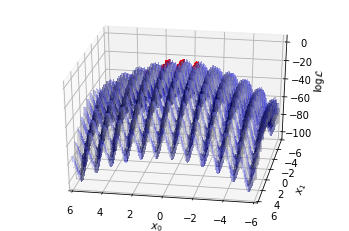

In [16]:
ax = utils.plot_surface(ln_posterior_grid, x_grid, y_grid, 
                        samples[0,:,:].reshape((-1, ndim)), 
                        lnprob[0,:].reshape((-1, 1)))              
ax.set_zlabel(r'$\log \mathcal{L}$')
ax.view_init(30,100)
plt.show(block=False)  

Alternatively, we can plot using a triangle plot of joint and marginalised distibutions using [getdist](https://getdist.readthedocs.io/).

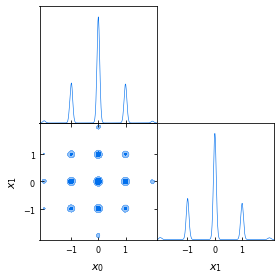

In [17]:
utils.plot_getdist(samples.reshape((-1, ndim)))